# Overcomplete retinal pyramid

## initialization parameters

In [1]:
mode= 'bilinear'
width = 32
r_min = width / 8 #width/16 
r_max = width / 2 #7 * width/16
#base_levels = 1.61803
base_levels = 2
n_sublevel = 4 #cette fois on en met 4
n_azimuth = 2 #var 2->24
n_theta = 3 #var 2->24
n_phase = 2

N_batch = 4
pattern = 'i05june05_static_street_boston_*.jpeg'

In [2]:
width/2

16.0

## libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os

In [5]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [6]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,POLO  -r -g -b

2020-03-12T14:37:30+01:00

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
torch 1.0.1.post2
POLO not installed

compiler   : GCC 8.3.0
system     : Linux
release    : 4.19.0-5-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
host name  : port-dauce
Git hash   : e2588d48fe0a07972809e8af9cbe5f05e1eba38b
Git repo   : https://github.com/bicv/POLO
Git branch : master


## loading an image

In [7]:
%ls ../data/

800px-Fox_Hunt_1893_Winslow_Homer.jpg
homer.jpg
i05june05_static_street_boston_p1010764.jpeg*
i05june05_static_street_boston_p1010764.npy
i05june05_static_street_boston_p1010764.pkl
i05june05_static_street_boston_p1010785.jpeg*
i05june05_static_street_boston_p1010785.pkl
i05june05_static_street_boston_p1010800.jpeg*
i05june05_static_street_boston_p1010800.pkl
i05june05_static_street_boston_p1010806.jpeg*
i05june05_static_street_boston_p1010806.pkl
i05june05_static_street_boston_p1010808.jpeg*
i05june05_static_street_boston_p1010808.pkl
rotating_snakes.JPG


In [8]:
from SLIP import imread

Tensor shape= torch.Size([1, 1, 768, 1024])


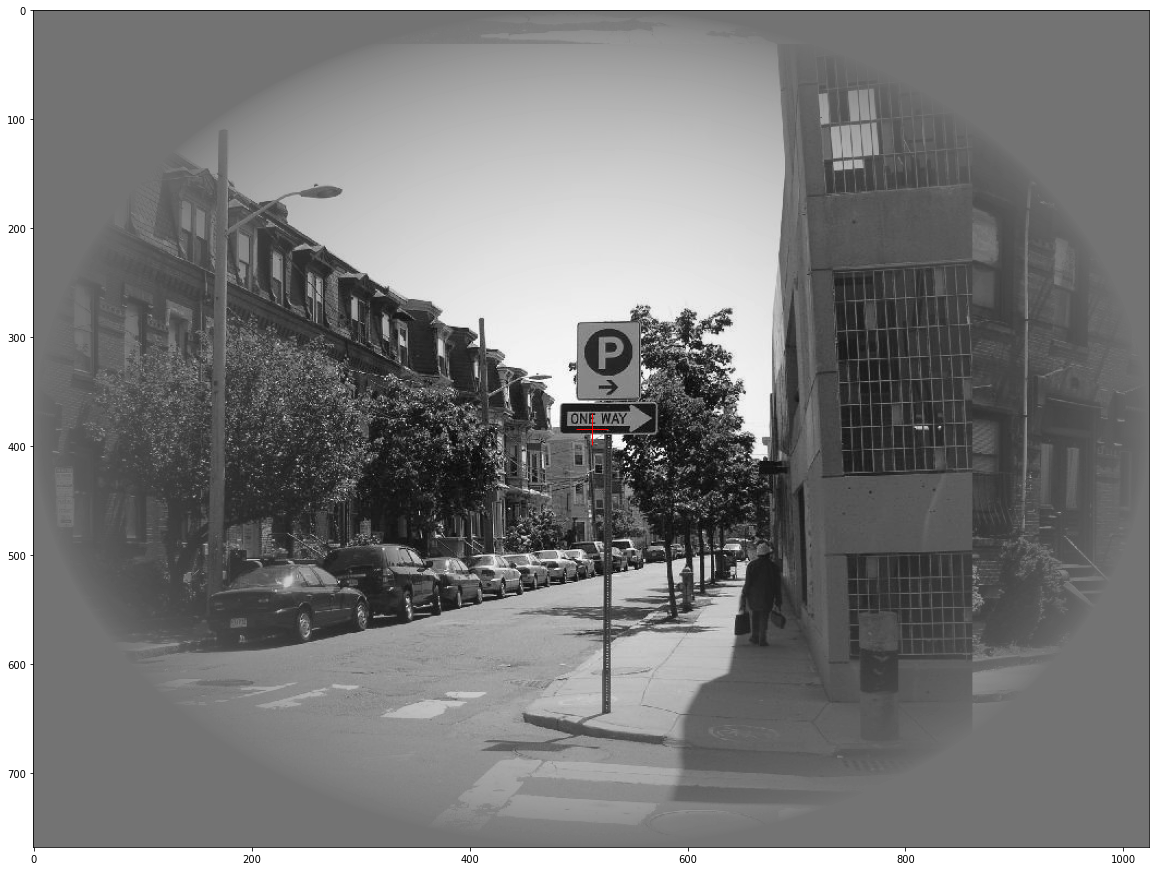

In [9]:
img_orig = imread('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom
from SLIP import Image
N_X, N_Y = img_orig.shape
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': True}

im = Image(pe)
img_orig -= img_orig.mean()
img_orig *= im.mask
img_tens = torch.Tensor(img_orig[None, None, ...])
print('Tensor shape=', img_tens.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

In [11]:
min(img_orig.flatten()), max(img_orig.flatten())

(-0.44570973576260037, 0.5408499926651285)

# using torch to build up a Gaussian pyramid



https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

## recursively down-sampling



In [12]:
from torch.nn.functional import interpolate
from torch.nn.functional import max_pool2d

In [13]:
%%timeit
interpolate(img_tens, scale_factor=1/2, mode=mode)

2.53 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
from torch.nn.functional import interpolate
img_down = img_tens
n_levels = 0
while max(img_down.shape[-2:]) > width :
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 768, 1024]) , n_levels= 1
Tensor shape= torch.Size([1, 1, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 5
Top tensor shape= torch.Size([1, 1, 24, 32]) , Final n_levels= 6


In [15]:
n_levels = int(np.log(np.max(img_orig.shape)/width)/np.log(base_levels)) + 1
print('Computed n_levels=', n_levels)

Computed n_levels= 6


Applying on the central crop of $32\times32$:

In [16]:
def cropped_pyramid(img_tens, width=width, base_levels=base_levels, verbose=False):
    
    N_batch, _, N_X, N_Y = img_tens.shape
    n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    
    img_crop = torch.zeros((N_batch, n_levels, width, width))

    img_down = img_tens.clone()
    for i_level in range(n_levels-1):
        img_residual = img_down.clone()
        img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
        img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)

        if verbose: print('Tensor shape=', img_down.shape, ', shape=', img_residual.shape)
        h_res, w_res = img_residual.shape[-2:]

        img_crop[:, i_level, :, :] = img_residual[:, 0, 
                            (h_res//2-width//2):(h_res//2+width//2), 
                            (w_res//2-width//2):(w_res//2+width//2)]

    h_res, w_res = img_down.shape[-2:]
    img_crop[:, n_levels-1, 
             (width//2-h_res//2):(width//2+h_res//2), 
             (width//2-w_res//2):(width//2+w_res//2)] = img_down[:, 0, :, :]
    #if verbose: print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)
    return img_crop

img_tens = torch.Tensor(img_orig[None, None, ...])
img_crop = cropped_pyramid(img_tens, verbose=True)

Tensor shape= torch.Size([1, 1, 384, 512]) , shape= torch.Size([1, 1, 768, 1024])
Tensor shape= torch.Size([1, 1, 192, 256]) , shape= torch.Size([1, 1, 384, 512])
Tensor shape= torch.Size([1, 1, 96, 128]) , shape= torch.Size([1, 1, 192, 256])
Tensor shape= torch.Size([1, 1, 48, 64]) , shape= torch.Size([1, 1, 96, 128])
Tensor shape= torch.Size([1, 1, 24, 32]) , shape= torch.Size([1, 1, 48, 64])


Tensor shape= torch.Size([1, 6, 32, 32])


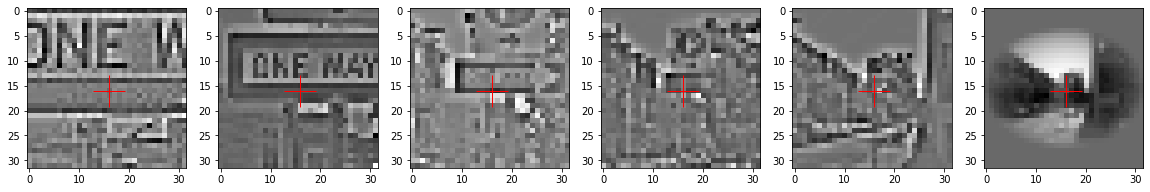

In [17]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

In [22]:
min(img_crop[0,2,...].flatten()), max(img_crop[0,2,...].flatten())

(tensor(-0.3744), tensor(0.3518))

## creating a set of filters

In [23]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [24]:
def local_filter(azimuth, theta, phase, sf_0=.25, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2 # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4440276868926977 1.0


In [25]:
def get_K(width=width, n_sublevel = n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, 
          n_phase = n_phase, r_min = width/6, r_max = width/3, log_density_ratio = 2, verbose=False):
    K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
    for i_sublevel in range(n_sublevel):
        #sf_0 = .25*(np.sqrt(2)**i_sublevel)
        #radius = width/4/(np.sqrt(2)**i_sublevel)
        # Di Carlo / Retina Warp
        
        b = np.log(log_density_ratio)  / (r_max - r_min)
        a = (r_max - r_min) / (np.exp (b * (r_max - r_min)) - 1)
        c = r_min - a
        r_ref = r_min + i_sublevel * (r_max - r_min) / n_sublevel
        r_prim =  a * np.exp(b * (r_ref - r_min)) + c
        radius =  r_prim
        d_r_prim = a * b * np.exp(b * (r_ref - r_min))
        p_ref = 4 * width / 32 
        p_loc = p_ref * d_r_prim
        sf_0 = 1 / p_loc
        if verbose: print('r_ref', r_ref)
        if verbose: print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
        for i_azimuth in range(n_azimuth):
            for i_theta in range(n_theta):
                for i_phase in range(n_phase):
                    azimuth = (i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth
                    theta = i_theta*np.pi/n_theta + azimuth
                    phase = i_phase*np.pi/n_phase
                    K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=azimuth, 
                                                                                   theta=theta, 
                                                                                   phase=phase, 
                                                                                   sf_0=sf_0, 
                                                                                   radius=radius)
    K = torch.Tensor(K)

    if verbose: print('K shape=', K.shape)
    if verbose: print('K min max=', K.min(), K.max())

    return K
K = get_K(verbose=True, r_min=r_min, r_max=r_max)

r_ref 4.0
i_sublevel, sf_0, radius 0 0.36067376022224085 4.0
r_ref 7.0
i_sublevel, sf_0, radius 1 0.3032892720469601 6.270485380032653
r_ref 10.0
i_sublevel, sf_0, radius 2 0.25503486164919736 8.970562748477139
r_ref 13.0
i_sublevel, sf_0, radius 3 0.21445790092553713 12.181513966089149
K shape= torch.Size([32, 32, 4, 2, 3, 2])
K min max= tensor(-1.) tensor(1.)


## Visual field covering

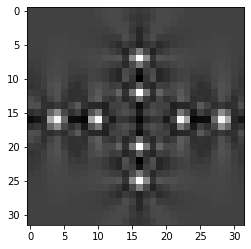

In [26]:
coefs = np.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, :, 0] = np.ones((n_sublevel, n_azimuth, n_theta))
coefs_tf = torch.Tensor(coefs)
img_dis = torch.tensordot(K, coefs_tf, dims=4)
plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

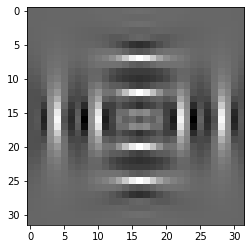

In [27]:
coefs = np.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, 0, 0] = np.ones((n_sublevel, n_azimuth))
coefs_tf = torch.Tensor(coefs)
img_dis = torch.tensordot(K, coefs_tf, dims=4)
plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

In [28]:
n_levels

6

In [29]:
n_levels

6

In [30]:
# initial # pixels
N_X * N_Y

786432

In [31]:
# Final # Filters
n_levels*n_sublevel*n_azimuth*n_theta*n_phase

288

In [32]:
# Compression rate
1 - n_levels*n_sublevel*n_azimuth*n_theta*n_phase / N_X / N_Y

0.9996337890625

In [33]:
# Acc map output
n_levels*n_sublevel*n_azimuth

48

## applying the filter

In [34]:
print('Tensor shape=', img_crop.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


In [35]:
%%timeit
out = torch.tensordot(img_crop, K,  dims=2)

50.8 µs ± 6.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
out = torch.tensordot(img_crop, K,  dims=2)
print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 6, 4, 2, 3, 2])


# reconstruction

## layer by layer from cropped central images

Tensor shape= torch.Size([1, 6, 32, 32])


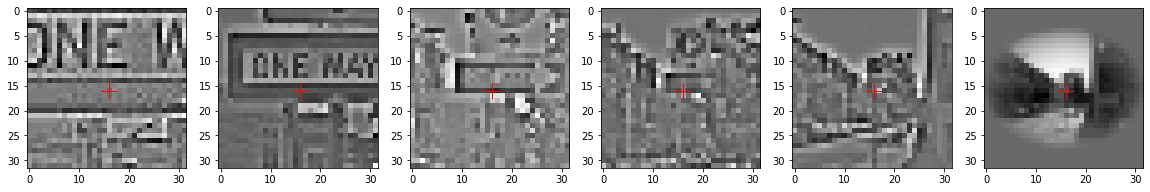

In [37]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=16);
print('Tensor shape=', img_crop.shape)

In [38]:
print('Tensor shape=', K.shape)
K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', K_.shape)

Tensor shape= torch.Size([32, 32, 4, 2, 3, 2])
Tensor shape= torch.Size([1024, 48])


In [39]:
print('Tensor shape=', out.shape)
out__ = out.reshape((1, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', out__.shape)

Tensor shape= torch.Size([1, 6, 4, 2, 3, 2])
Tensor shape= torch.Size([1, 6, 48])


In [40]:
K_inv = torch.pinverse(K_)
print('Tensor shape=', K_inv.shape)

Tensor shape= torch.Size([48, 1024])


In [41]:
img_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((1, n_levels, width, width))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


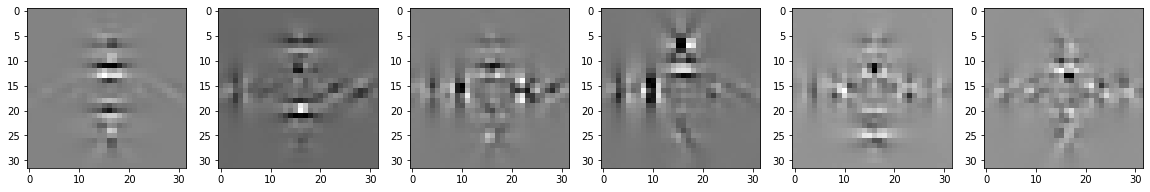

In [42]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

In [36]:
int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1

6

In [43]:
min(img_rec.flatten()), max(img_rec.flatten())

(tensor(-0.2562), tensor(0.3045))

## inverse pyramid from the coefficients

In [37]:
def inverse_pyramid(out, K_inv, N_X=N_X, N_Y=N_Y, 
                    n_sublevel=n_sublevel, n_azimuth = n_azimuth, n_theta = n_theta, n_phase=n_phase,
                    base_levels=base_levels, verbose=False):
    N_batch = out.shape[0]
    # width =  K_inv.shape[0]
    #n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
    #n_sublevel, n_azimuth, n_theta, n_phase = K_inv.shape[2:]
    #print('n_levels =', n_levels)
    out__ = out.reshape((N_batch, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
    #K_ = K.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    #K_inv = torch.pinverse(K_)
    img_crop_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((N_batch, n_levels, width, width))

    img_rec = img_crop_rec[:, -1, :, :].unsqueeze(1)
    for i_level in range(n_levels-1)[::-1]: # from the top to the bottom of the pyramid
        img_rec = interpolate(img_rec, scale_factor=base_levels, mode=mode)
        h_res, w_res = img_rec.shape[-2:]
        img_rec[:, 0, (h_res//2-width//2):(h_res//2+width//2), (w_res//2-width//2):(w_res//2+width//2)] += img_crop_rec[:, i_level, :, :]
    img_rec = img_rec[:, :, (h_res//2-N_X//2):(h_res//2+N_X//2), (w_res//2-N_Y//2):(w_res//2+N_Y//2)]

    return img_rec

img_rec = inverse_pyramid(out, K_inv)

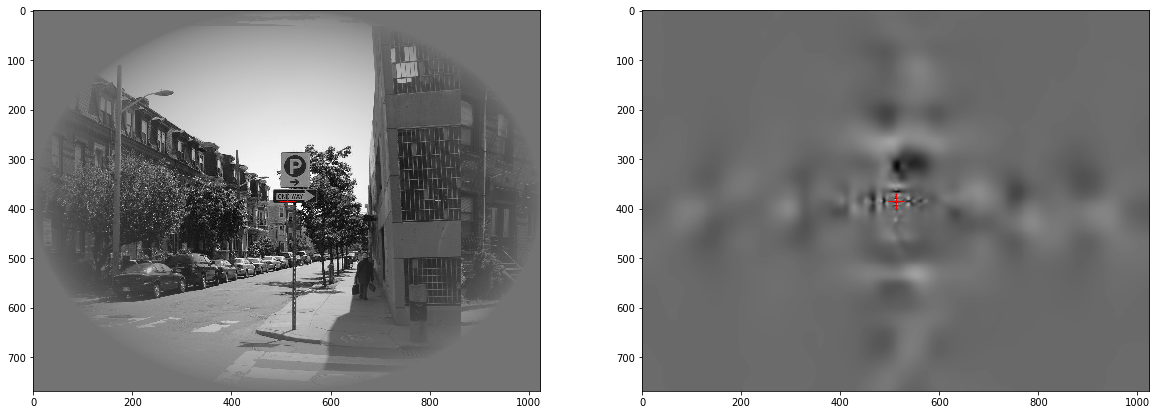

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    ax.imshow(img[0, 0, :, :].numpy(), cmap='gray')
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);

# Norms
$|A|=\left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

In [39]:
def norm_diff(img_orig, img):
    difference=img[0, 0, :, :].numpy()-img_orig
    return np.linalg.norm(difference, ord=None, axis=None, keepdims=False)

In [40]:
def pyr_transfo_ret(img_orig, K_azym_thet, n_azimuth = n_azimuth, n_theta = n_theta):
    img_crop = cropped_pyramid(torch.Tensor(img_orig[None, None, ...]), verbose=False)
    out = torch.tensordot(img_crop, K_azym_thet,  dims=2)
    K_ = K_azym_thet.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
    K_azym_thet_inv = torch.pinverse(K_)
    img_rec = inverse_pyramid(out, K_azym_thet_inv, n_azimuth = n_azimuth, n_theta = n_theta)
    return img_rec
    

### Distances

2
3
4
torch.Size([1, 1, 768, 1024])


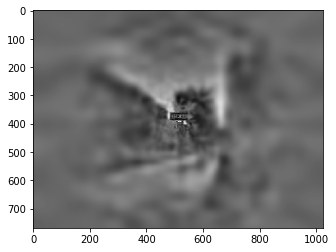

5
6
7
torch.Size([1, 1, 768, 1024])


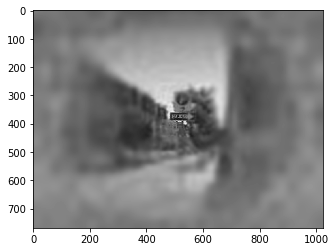

8
9
10
torch.Size([1, 1, 768, 1024])


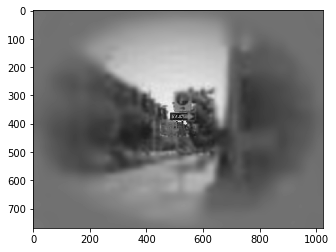

11
12
13
torch.Size([1, 1, 768, 1024])


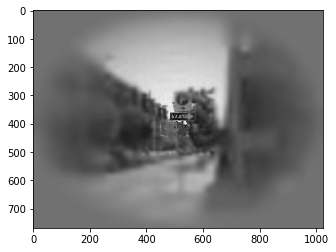

14
15
16
torch.Size([1, 1, 768, 1024])


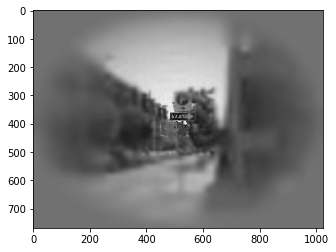

17
18
19
torch.Size([1, 1, 768, 1024])


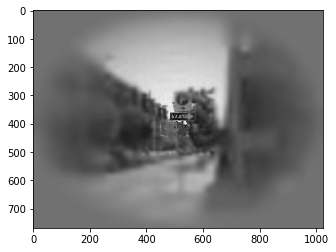

20
21
22
torch.Size([1, 1, 768, 1024])


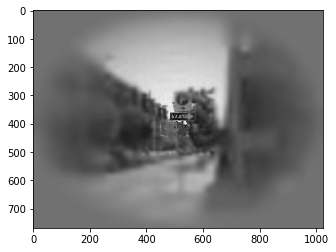

23
24


In [70]:
def toutes_les_distances(img_orig): #azymut en ligne, theta en colonne
    dist_thet_azim=np.zeros([25,25])

    for i in range(2,25):
        print(i)
        for j in range(2,25):
            K_azym_thet = get_K(verbose=False, n_azimuth = i, n_theta = j, r_min=r_min, r_max=r_max)
            img_rec=pyr_transfo_ret(img_orig, K_azym_thet, n_azimuth = i, n_theta = j)
            dist_thet_azim[i][j]=norm_diff(img_orig, img_rec)
            if i%3==1 and j==10:
                print(img_rec.shape)
                plt.imshow(img_rec[0,0,...], cmap='gray')
                plt.show()
    return  dist_thet_azim

dist_thet_azim=toutes_les_distances(img_orig)



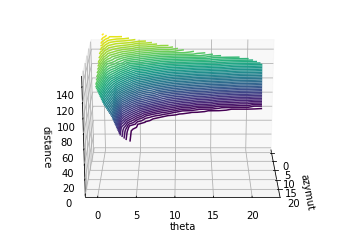

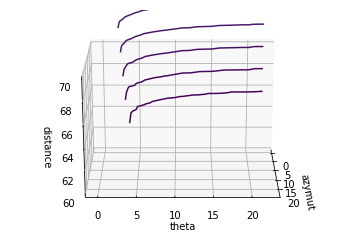

In [117]:
copie_distances = dist_thet_azim.copy()

from mpl_toolkits import mplot3d
%matplotlib inline


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(x, np.arange(23), copie_distances[2:,2:], 60)
ax.set_xlabel('azymut')
ax.set_ylabel('theta')
ax.set_zlabel('distance');
ax.set_zlim(0, 150);

ax.view_init(20, 0)


fig2 = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(np.arange(15), np.arange(15), copie_distances[10:,10:], linewidth=0, antialiased=False)
ax.contour3D(np.arange(23), np.arange(23), copie_distances[2:,2:], 60)
ax.set_xlabel('azymut')
ax.set_ylabel('theta')
ax.set_zlabel('distance')
ax.set_zlim(60, 70);


ax.view_init(20, 0)


In [125]:

from mpl_toolkits import mplot3d
%matplotlib inline

x=np.arange(23)
y=np.arange(23)
X,Y = np.meshgrid(x,y)
Z=copie_distances[2:,2:]
ax.plot_surface(X, Y, Z)
ax.set_xlabel('azymut')
ax.set_ylabel('theta')
ax.set_zlabel('distance');
ax.set_zlim(0, 150);

plt.show()

Text(0.5,0,'distance')

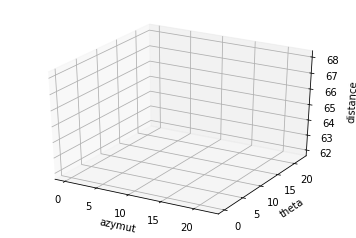

In [115]:
for i in range(25):
    for j in range(25):
        copie_distances[i][j]=65

fig2 = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(np.arange(15), np.arange(15), copie_distances[10:,10:], linewidth=0, antialiased=False)
ax.contour3D(np.arange(23), np.arange(23), copie_distances[2:,2:]? 60)
ax.set_xlabel('azymut')
ax.set_ylabel('theta')
ax.set_zlabel('distance')
#ax.set_zlim(60, 70);

array([[65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
       [65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
       [65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
       [65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
       [65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
       [65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
       [65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.,
        65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65., 65.],
      

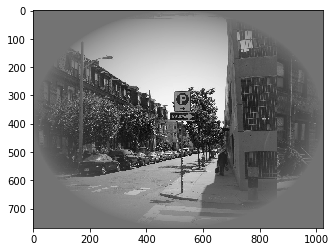

In [110]:
fig = plt.figure()

plt.imshow(img_orig, cmap='gray')

# optimizing the reconstruction

## defining a dataloader

In [45]:
def get_dataloader(K, N_batch, pattern=pattern, 
                   ds=ds, saccade_radius=.5, verbose=False):
    from glob import glob
    imgs = []
    for fname in glob(os.path.join('../data', pattern)):
        img_orig = imread(fname)
        if ds>1: img_orig = img_orig[::ds, ::ds]
        from SLIP import Image
        pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True}
        im = Image(pe)
        imgs.append(img_orig)
                          
    N_imgs = len(imgs)
    if verbose: print('N_imgs ', N_imgs )
    N_X, N_Y = img_orig.shape
    width = K.shape[0]
    #n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1

    target = torch.zeros((N_batch, 1, N_X, N_Y))
    for i in range(N_batch):
        # generate random saccades
        target_ = imgs[int(N_imgs*np.random.rand())].copy()
        sacc_x, sacc_y = np.int(saccade_radius*N_X*np.random.rand()), np.int(saccade_radius*N_Y*np.random.rand())
        if verbose: print('sacc_x, sacc_y ', sacc_x, sacc_y )
        target_ = np.roll(target_, sacc_y, axis=1)
        target_ = np.roll(target_, sacc_x, axis=0) 
        target[i, :, :, :] = torch.from_numpy(target_[None, :, :])

    if verbose: print(target.shape)
    img_crop = cropped_pyramid(target, verbose=verbose)
    if verbose: print(img_crop.shape)
    out = torch.tensordot(img_crop, K, dims=2)

    from torch.utils.data import TensorDataset, DataLoader
    dataloader = DataLoader(TensorDataset(target, out), batch_size=N_batch, shuffle=False, drop_last=False)
    return dataloader

dataloader = get_dataloader(K, N_batch, verbose=True)

N_imgs  5
sacc_x, sacc_y  359 118
sacc_x, sacc_y  161 36
sacc_x, sacc_y  176 284
sacc_x, sacc_y  324 456
torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 384, 512]) , shape= torch.Size([4, 1, 768, 1024])
Tensor shape= torch.Size([4, 1, 192, 256]) , shape= torch.Size([4, 1, 384, 512])
Tensor shape= torch.Size([4, 1, 96, 128]) , shape= torch.Size([4, 1, 192, 256])
Tensor shape= torch.Size([4, 1, 48, 64]) , shape= torch.Size([4, 1, 96, 128])
Tensor shape= torch.Size([4, 1, 24, 32]) , shape= torch.Size([4, 1, 48, 64])
torch.Size([4, 6, 32, 32])


## validating on the test set

In [46]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

0 torch.Size([4, 1, 768, 1024]) torch.Size([4, 6, 4, 2, 3, 2])


In [47]:
img_rec = inverse_pyramid(out, K_inv)
print('img_rec.shape', img_rec.shape)

img_rec.shape torch.Size([4, 1, 768, 1024])


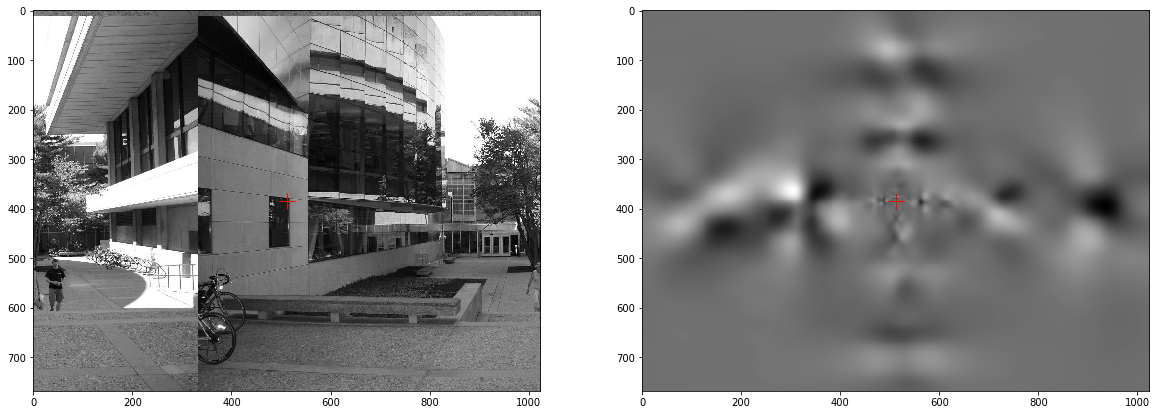

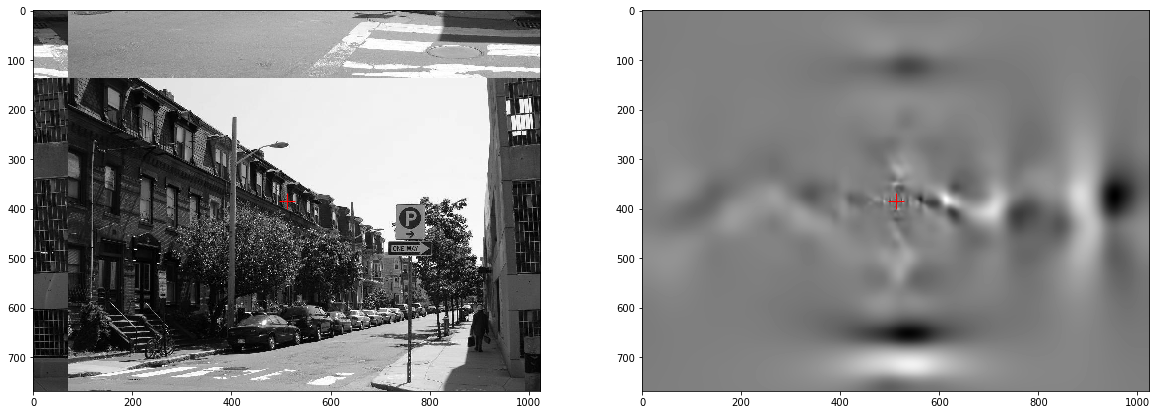

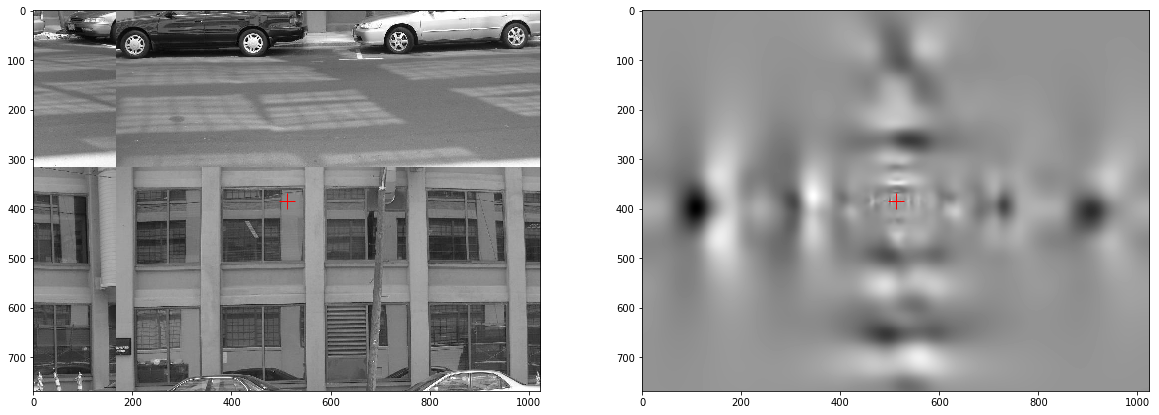

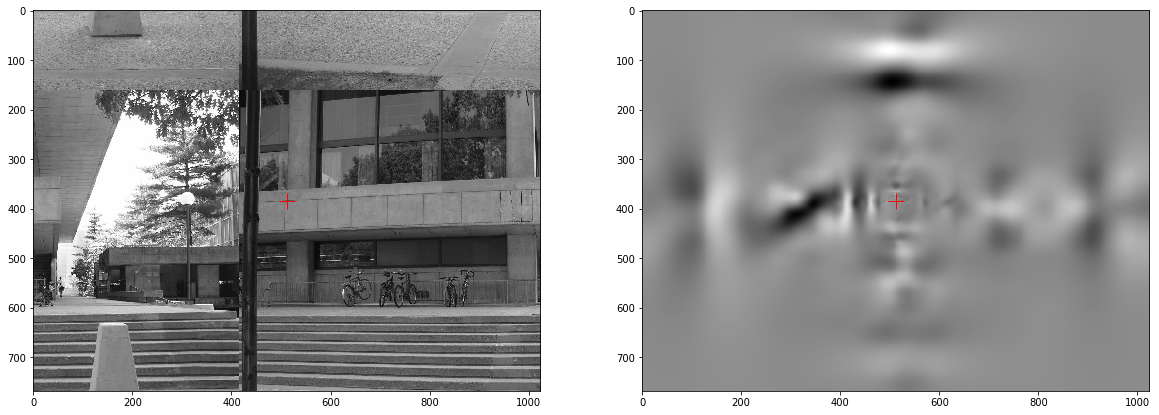

In [48]:
for i_batch in range(N_batch):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);


## testing different parameters

In [49]:
K = get_K(n_azimuth = 9)

In [50]:
test_dataloader = get_dataloader(K, N_batch, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)

0 torch.Size([4, 1, 768, 1024]) torch.Size([4, 6, 4, 9, 3, 2])


In [51]:
img_rec = inverse_pyramid(out, K_inv)
print('img_rec.shape', img_rec.shape)

RuntimeError: shape '[4, 6, 48]' is invalid for input of size 5184

In [ ]:
for i_batch in range(N_batch):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    for ax, img in zip(axs, [target[i_batch, 0, :, :], img_rec[i_batch, 0, :, :]]):
        ax.imshow(img.numpy(), cmap='gray')
        ax.plot([N_Y//2], [N_X//2], 'r+', ms=16);


## estimating running time in realistic conditions (no downscaling, ds=1)

In [ ]:
%%timeit
K = get_K()

In [ ]:
#N_batch = 128
K = get_K()
test_dataloader = get_dataloader(K, N_batch, ds=1, verbose=False)
for batch_idx, (target, out) in enumerate(test_dataloader):
    print(batch_idx, target.shape, out.shape)
    N_X, N_Y = target.shape[-2:]
    img_crop = cropped_pyramid(target)
    out = torch.tensordot(img_crop, K,  dims=2)
    img_rec = inverse_pyramid(out, K_inv, N_X, N_Y)

In [ ]:
%%timeit
img_crop = cropped_pyramid(target)

In [ ]:
%%timeit
out = torch.tensordot(img_crop, K,  dims=2)

In [ ]:
out = torch.tensordot(img_crop, K,  dims=2)

In [ ]:
%%timeit
img_rec = inverse_pyramid(out, K_inv, N_X, N_Y)